# Dog Breed Image Classification with ML



The following code blocks attempt to layout the machine learning workflow for a deep Convolutional Neural Network based on the ResNet-18 and Transfer Learning algorithms. The neueral network will be trainined against a ready dataset of labeled images of dogs falling under 133 categories, evaluated and finally deployed. 


In [1]:
#Installation of all packages a required 
!pip install smdebug #Monitoring model performance
!pip install torchvision #Contains datasets & transforms for computer vision

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip
#!find dogImages/. -type f | wc -l
#!ls dogImages/valid -l | wc -l
#!find dogImages/train/. -type f | wc -l

In [4]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "cd0387-dog-breeds"

role = sagemaker.get_execution_role()

In [5]:
# TODO: Upload the data to an S3 bucket. You can use the sagemaker_session object, boto3 or the AWS CLI
#inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix=prefix)
#print("input spec (in this case, just an S3 path): {}".format(inputs))

In [6]:
import torchvision
import torch
from torchvision import datasets, models, transforms
import os

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './dogImages'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
print(class_names)

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog', '044.Cane_corso', '045.Cardigan_welsh_

In [8]:
print(dataset_sizes)

{'train': 6680, 'valid': 835}


In [9]:
print(image_datasets)

{'train': Dataset ImageFolder
    Number of datapoints: 6680
    Root location: ./dogImages/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'valid': Dataset ImageFolder
    Number of datapoints: 835
    Root location: ./dogImages/valid
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([ 11,  50, 120,   6])


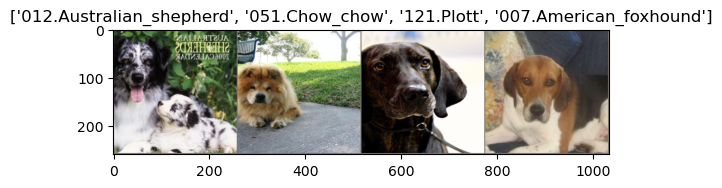

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#show images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [11]:
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput

In [12]:
#!pip install amazon-ai-s3-data-loader

In [13]:
#TODO: Declare your HP ranges, metrics etc.

hyperparameters = {
    #"gpu": True,
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([8, 16, 32, 64, 128]),
    "epochs": IntegerParameter(2, 10),
    #"model": "resnet50",
}

In [14]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [15]:
#TODO: Create estimators for your HPs
s3_data_path = 's3://sagemaker-us-east-1-733710257842/cd0387-dog-breeds/'
s3_output_path = 's3://sagemaker-us-east-1-733710257842/cd0387-dog-breeds/output'

# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    source_dir="scripts",
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    output_path = s3_output_path,
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameters,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,
    objective_type=objective_type,
) #TODO: Create your HyperparameterTuner Object# TODO: Your HP tuner here

In [16]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "cd0387-dog-breeds"

role = sagemaker.get_execution_role()

print(bucket)
print(prefix)

sagemaker-us-east-1-733710257842
cd0387-dog-breeds


In [17]:
train_data_loc = 's3://sagemaker-us-east-1-733710257842/cd0387-dog-breeds'
#val_data_loc = 's3://sagemaker-us-east-1-433073421675/cd0387-dog-breeds/valid'
#test_data_loc = 's3://sagemaker-us-east-1-433073421675/cd0387-dog-breeds/test'

channels = {
    'training': train_data_loc,
    #'validation': val_data_loc,
    #'test': test_data_loc
}

In [18]:
# TODO: Fit your HP Tuner
tuner.fit(inputs=channels, wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................!


In [19]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_hp = best_estimator.hyperparameters()


2024-04-10 17:14:07 Starting - Preparing the instances for training
2024-04-10 17:14:07 Downloading - Downloading the training image
2024-04-10 17:14:07 Training - Training image download completed. Training in progress.
2024-04-10 17:14:07 Uploading - Uploading generated training model
2024-04-10 17:14:07 Completed - Resource released due to keep alive period expiry


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [20]:
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile

In [21]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=5)
)
collection_config = [CollectionConfig(
    name="CrossEntropyLoss_output_0", 
    parameters={
        "include_regex": "CrossEntropyLoss_output_0",
        "train.save_interval": "5", 
        "eval.save_interval": "1"})]
    
debugger_config = DebuggerHookConfig(
    collection_configs=collection_config
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [22]:
print(best_hp)

{'_tuning_objective_metric': '"average test loss"', 'batch-size': '"32"', 'epochs': '2', 'lr': '0.00341748016096283', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"pytorch-training-2024-04-10-17-04-32-774"', 'sagemaker_program': '"hpo.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-733710257842/pytorch-training-2024-04-10-17-04-32-774/source/sourcedir.tar.gz"'}


In [23]:
# TODO: Create and fit an estimator
best_hyperparameters = {'batch_size': int(best_hp['batch-size'].strip('"')), 'epochs': best_hp['epochs'], 'lr': best_hp['lr'] }


estimator = PyTorch(
    entry_point="train_model.py",
    source_dir="scripts",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    output_path = s3_output_path,
    hyperparameters = best_hyperparameters,
    profiler_config = profiler_config, 
    debugger_hook_config = debugger_config, 
    rules = rules 
)

In [ ]:
estimator.fit({'training': train_data_loc}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-04-10-17-25-43-299


2024-04-10 17:25:43 Starting - Starting the training job...
2024-04-10 17:26:09 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.

In [34]:
path = estimator.latest_job_debugger_artifacts_path()
print(path)

s3://sagemaker-us-east-1-733710257842/cd0387-dog-breeds/output/pytorch-training-2024-04-10-17-25-43-299/debug-output


In [35]:
import smdebug.trials as smd
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt

path = estimator.latest_job_debugger_artifacts_path()
#path = "s3://sagemaker-us-east-1-433073421675/cd0387-dog-breeds/output/pytorch-training-2024-03-31-16-43-47-880/debug-output"
trial = smd.create_trial(path=path)
print(f"Saved these tensors: {trial.tensor_names()}")



[2024-04-10 17:58:39.695 ip-172-16-131-137.ec2.internal:21897 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-733710257842/cd0387-dog-breeds/output/pytorch-training-2024-04-10-17-25-43-299/debug-output
[2024-04-10 17:58:40.045 ip-172-16-131-137.ec2.internal:21897 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 234 more expected)', IncompleteRead(0 bytes read, 234 more expected)) while reading s3://sagemaker-us-east-1-733710257842/cd0387-dog-breeds/output/pytorch-training-2024-04-10-17-25-43-299/debug-output/index/000000000/000000000110_worker_0.json . Will retry now
[2024-04-10 17:58:44.074 ip-172-16-131-137.ec2.internal:21897 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-04-10 17:58:45.097 ip-172-16-131-137.ec2.internal:21897 INFO trial.py:210] Loaded all steps
Saved these tensors: ['CrossEntropyLoss_output_0'

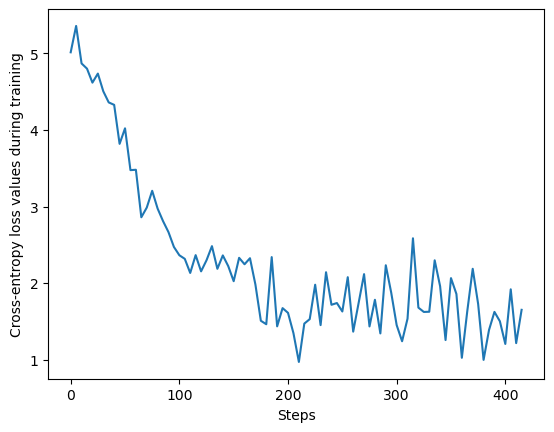

In [36]:
# TODO: Display the profiler output
plt.ylabel('Cross-entropy loss values during training')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=ModeKeys.TRAIN),list(trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.TRAIN).values()))
plt.show()

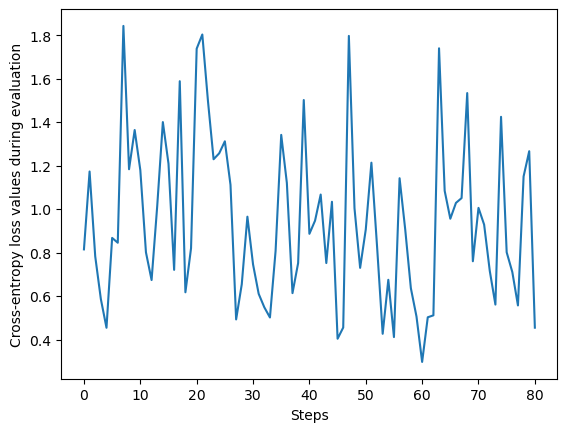

In [37]:
plt.ylabel('Cross-entropy loss values during evaluation')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=ModeKeys.EVAL),list(trial.tensor('CrossEntropyLoss_output_0').values(mode=ModeKeys.EVAL).values()))
plt.show()

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it? 

The high flactuation of the Cross-entropy loss values during evaluation indicates possible overfitting of the model. A possible fix would be to increase the training dataset.  

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

There would be an obvious error if the Cross-entropy loss values during training values didn't not tend towards 0. That would mean the model performance is quite low. 

In [38]:
import smdebug
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

training_job_name = estimator.latest_training_job.job_name
region = "us-east-1"

tj = TrainingJob(training_job_name, region)



ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-733710257842/cd0387-dog-breeds/output', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 5, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 5, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 5, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 5, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 5, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-733710257842/cd0387-dog-breeds/output/pytorch-training-2024-04-10-17-25-43-299/profiler-output


In [39]:
rule_output_path = estimator.output_path ++ estimator.latest_training_job.job_name + "/rule-output"

In [43]:
#rule_output_path = "s3://sagemaker-us-east-1-433073421675/sagemaker/cd0387-project-resnet-18/output/pytorch-training-2024-03-31-16-43-47-880/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-733710257842/cd0387-dog-breeds/outputpytorch-training-2024-04-10-17-25-43-299/rule-output


In [44]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

In [ ]:
import IPython

IPython.display.HTML(filename="ProfilerReport/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

from sagemaker.pytorch import PyTorchModel

# Create a PyTorchModel object
# Ref https://github.com/aws/amazon-sagemaker-examples/blob/main/frameworks/pytorch/get_started_mnist_deploy.ipynb
pytorch_model = PyTorchModel(
    model_data=estimator.model_data,
    role=role,
    source_dir="scripts",
    entry_point='inference.py', #Required for model preprocessing
    framework_version='1.8.0',
    py_version='py36',
)

In [ ]:
print(estimator.model_data)

In [ ]:
# Deploy the model
predictor = pytorch_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
)

In [ ]:
# TODO: Run an prediction on the endpoint
from PIL import Image
import io

test_image_path = "./dogImages/test/081.Greyhound/Greyhound_05526.jpg"

with open(test_image_path, "rb") as f:
    payload = f.read()
    print("Display Image class 101:")
    display(Image.open(io.BytesIO(payload)))

response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
predicted_dog_breed = np.argmax(response, 1) + 1

print(f"Prediction: {predicted_dog_breed}")


#image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
#response = predictor.predict(image)

In [ ]:
import boto3

# Create a SageMaker client
sagemaker = boto3.client('sagemaker')

response = sagemaker.list_endpoints(SortBy='CreationTime', SortOrder='Descending')
latest_endpoint = response['Endpoints'][0]['EndpointName']
runtime = boto3.client('sagemaker-runtime')

# Image Data Type Reference - https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-processing-job-data-format-image.html
response = runtime.invoke_endpoint(
    EndpointName=latest_endpoint,
    ContentType='image/jpeg',
    Body=payload  
)

print(response)

In [ ]:
import json

streaming_body = response['Body']
json_response_body = streaming_body.read()
decoded_response_body = json_response_body.decode('utf-8')
prediction = json.loads(decoded_response_body)

print(prediction)

In [ ]:
import numpy as np

# Convert the prediction to a numpy array
prediction_array = np.array(prediction)

# Find the index of the maximum value
predicted_class = np.argmax(prediction_array)

print(class_names[predicted_class])

In [ ]:
data_transforms = {
    'test': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = './dogImages'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
class_names = image_datasets['test'].classes

inputs, classes = next(iter(dataloaders['train']))

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
#predictor.delete_endpoint()

In [ ]:
!pip freeze > requirements.txt